## Dependencies

In [1]:
!pip install --quiet efficientnet

In [2]:
import warnings, json, re
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
base_model_path = '/kaggle/input/efficientnet/'
dataset_path = 'melanoma-256x256'

config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 1024,
  "EPOCHS": 40,
  "LEARNING_RATE": 3e-4, 
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "BASE_MODEL_PATH": base_model_path + 'efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 1024,
 'EPOCHS': 40,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'BASE_MODEL_PATH': '/kaggle/input/efficientnet/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


## Auxiliar functions

In [6]:
# Datasets utility functions
LABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "target": tf.io.FixedLenFeature([], tf.int64), # shape [] means single element
    "image_name": tf.io.FixedLenFeature([], tf.string),
    # meta features
    "patient_id": tf.io.FixedLenFeature([], tf.int64),
    "sex": tf.io.FixedLenFeature([], tf.int64),
    "age_approx": tf.io.FixedLenFeature([], tf.int64),
    "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
    "diagnosis": tf.io.FixedLenFeature([], tf.int64)
}

def decode_image(image_data, height, width, channels):
    image = tf.image.decode_jpeg(image_data, channels=channels)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, channels])
    return image

def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)


def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'], seed=SEED)
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'], seed=SEED)
        
    if p_crop >= .7: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.6), int(config['WIDTH']*.6), config['CHANNELS']], seed=SEED)
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']], seed=SEED)
        elif p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']], seed=SEED)
        else:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']], seed=SEED)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])
    
        
    ## Pixel-level transforms
    if p_pixel >= .4: # pixel transformations
        if p_pixel >= .85:
            image['input_image'] = tf.image.random_saturation(image['input_image'], lower=0, upper=2, seed=SEED)
        elif p_pixel >= .65:
            image['input_image'] = tf.image.random_contrast(image['input_image'], lower=.8, upper=2, seed=SEED)
        elif p_pixel >= .5:
            image['input_image'] = tf.image.random_brightness(image['input_image'], max_delta=.2, seed=SEED)
        else:
            image['input_image'] = tf.image.adjust_gamma(image['input_image'], gamma=.5)

    return image, label


def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 8.57e-06


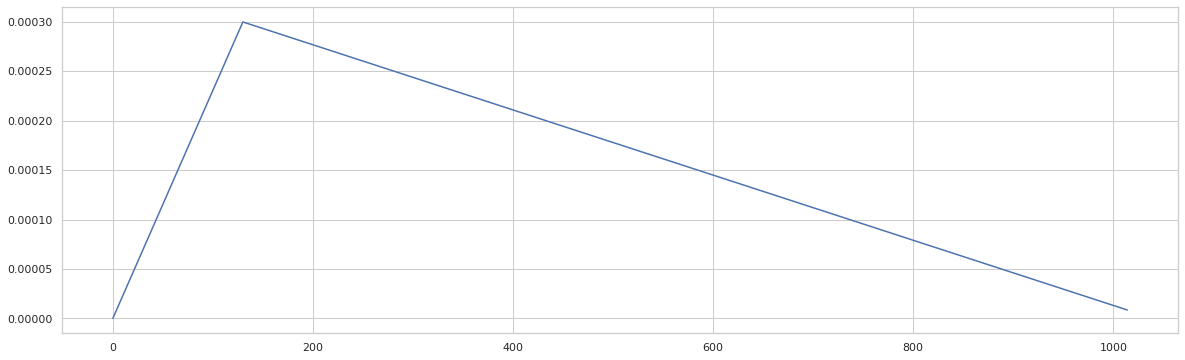

In [7]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 26880 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, step_size)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [8]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_PATH'], 
                                    include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [9]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    step_size = train_size // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps=total_steps, warmup_steps=warmup_steps, 
                                                 hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                 lr_max=lr_max, lr_min=lr_min)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer, loss=losses.BinaryCrossentropy(), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
Epoch 1/40
24/24 - 27s - auc: 0.4708 - loss: 0.6519 - val_auc: 0.4662 - val_loss: 0.7207
Epoch 2/40
24/24 - 10s - auc: 0.5528 - loss: 0.2135 - val_auc: 0.5789 - val_loss: 0.4069
Epoch 3/40
24/24 - 11s - auc: 0.7654 - loss: 0.0798 - val_auc: 0.5918 - val_loss: 0.1721
Epoch 4/40
24/24 - 10s - auc: 0.8587 - loss: 0.0727 - val_auc: 0.5932 - val_loss: 0.1209
Epoch 5/40
24/24 - 10s - auc: 0.8875 - loss: 0.0676 - val_auc: 0.6149 - val_loss: 0.1028
Epoch 6/40
24/24 - 8s - auc: 0.9216 - loss: 0.0616 - val_auc: 0.5701 - val_loss: 0.1069
Epoch 7/40
24/24 - 10s - auc: 0.9412 - loss: 0.0564 - val_auc: 0.5734 - val_loss: 0.1019
Epoch 8/40
24/24 - 10s - auc: 0.9480 - loss: 0.0525 - val_auc: 0.6129 - val_loss: 0.1007
Epoch 9/40
24/24 - 10s - auc: 0.9604 - loss: 0.0475 - val_auc: 0.6430 - val_loss: 0.0977
Epoch 10/40
24/24 - 10s - auc: 0.9733 - loss: 0.0414 - val_auc: 0.7483 - val_loss: 0.0872
Epoch 11/40
24/24 - 8s - auc: 0.9725 - loss: 0.0375 - val_auc: 0.6532 - val_loss: 0.1071
Epoch 12/40


## Model loss graph

Fold: 0


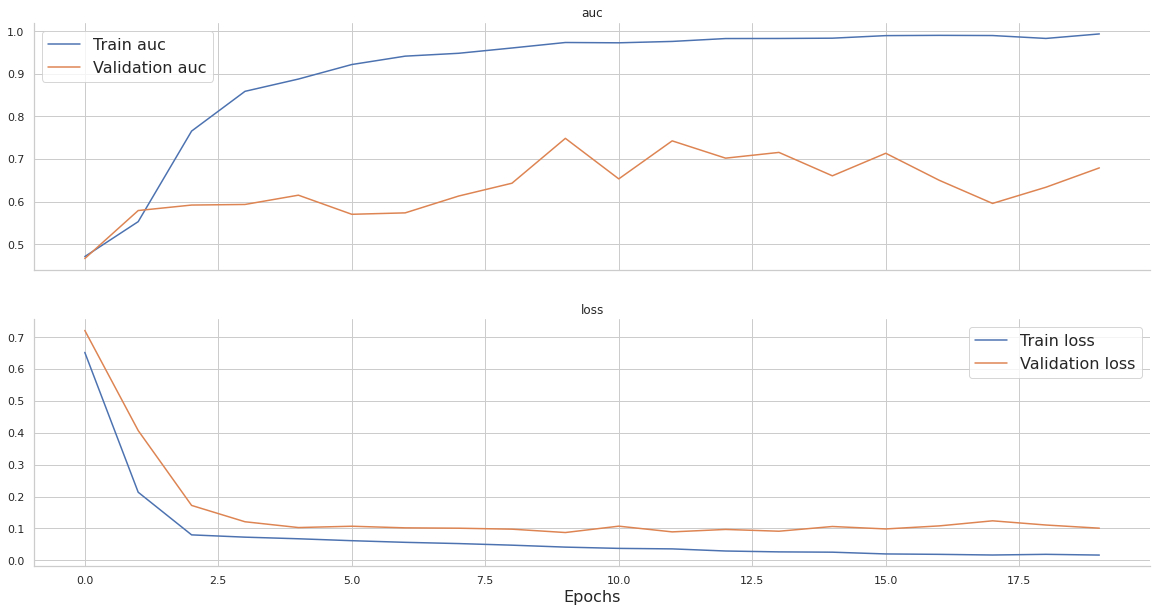

Fold: 1


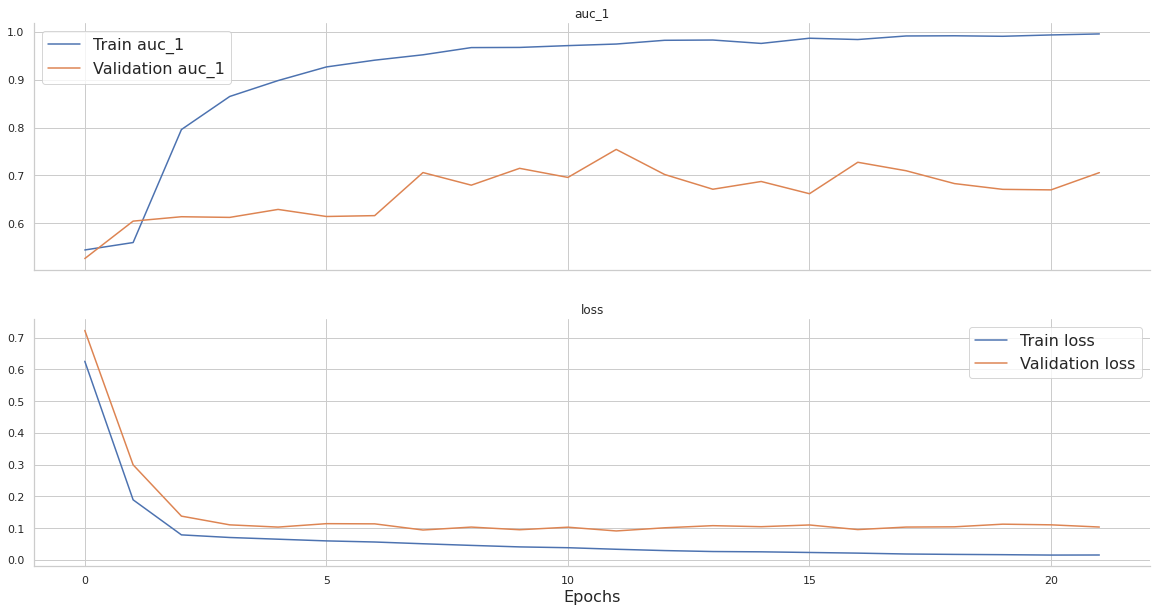

Fold: 2


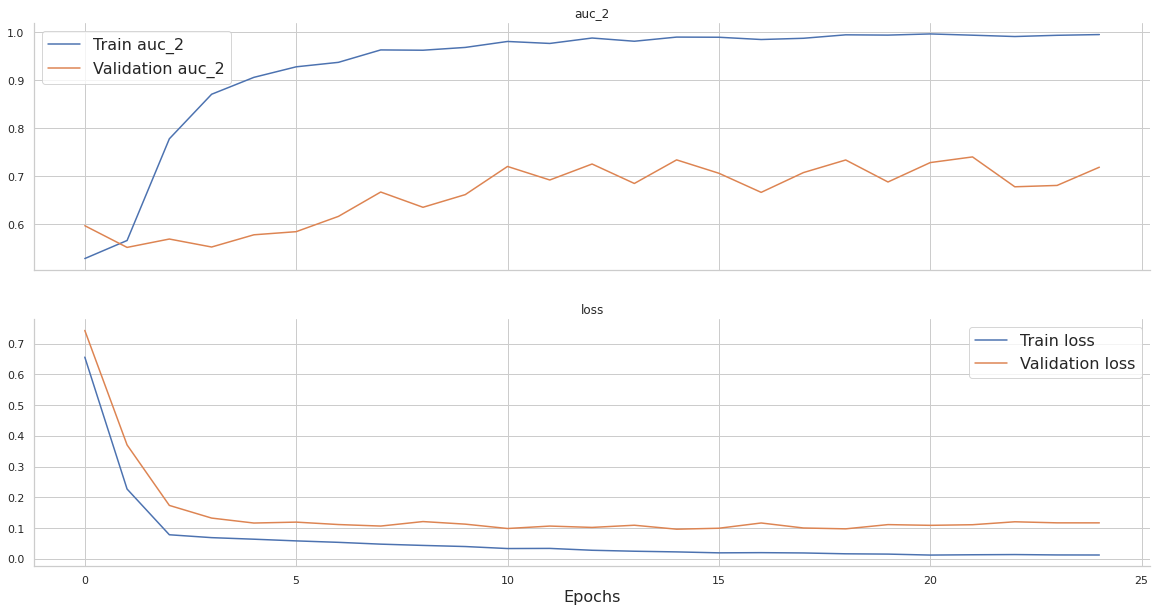

Fold: 3


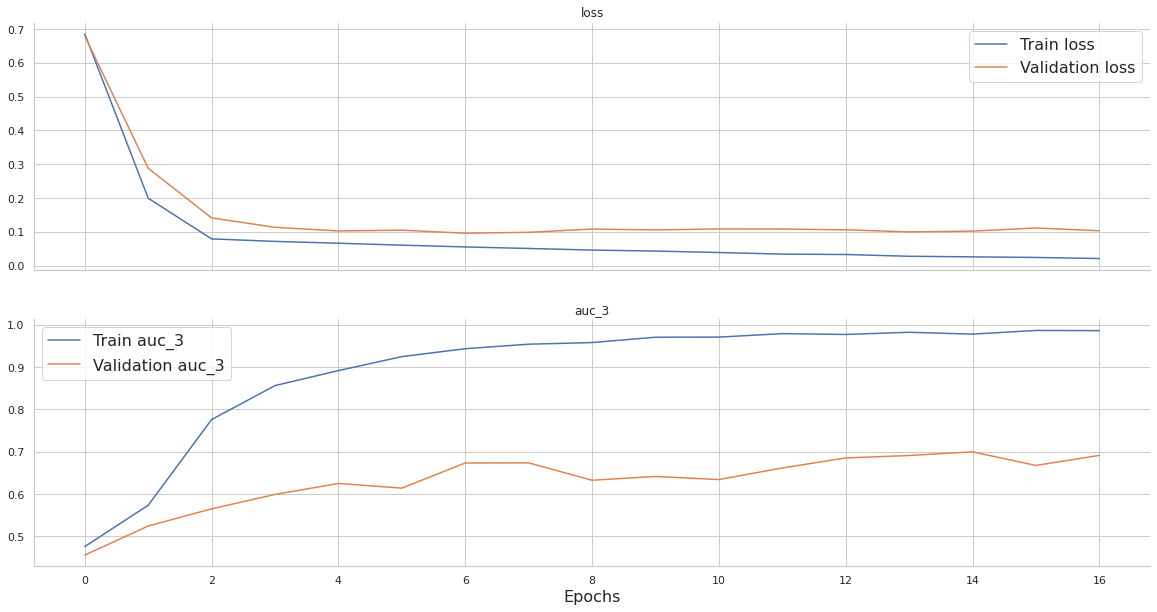

Fold: 4


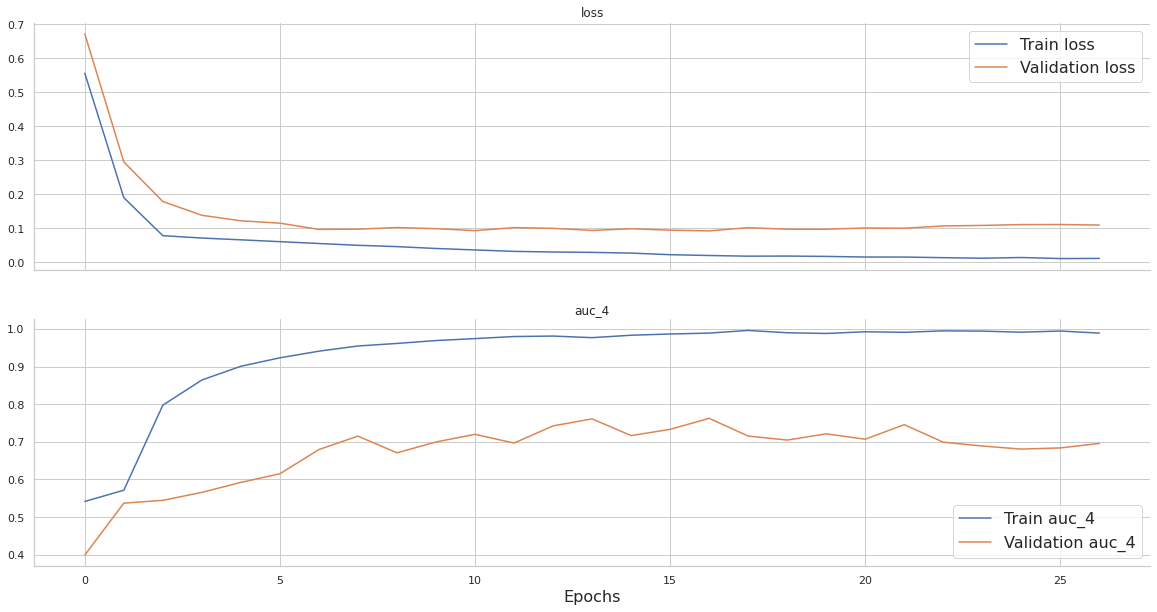

In [10]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold}')
    plot_metrics(history_list[n_fold])

# Model evaluation

In [11]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.930259,0.788910,0.141349,0.910633,0.781895,0.978782,0.818336,0.998360,0.828598,0.763617,0.701604,0.999900,0.814116
Accuracy,0.988113,0.982040,0.006073,0.982248,0.982979,0.984431,0.982134,0.993758,0.981490,0.982469,0.981944,0.997659,0.981651
Precision,0.784454,0.220000,0.564454,1.000000,0.000000,0.950820,0.400000,0.980952,0.450000,0.000000,0.000000,0.990499,0.250000
Recall,0.331796,0.025121,0.306675,0.004515,0.000000,0.122363,0.018182,0.656051,0.079646,0.000000,0.000000,0.876050,0.027778
F1-score,0.388367,0.044024,0.344343,0.008989,0.000000,0.216822,0.034783,0.786260,0.135338,0.000000,0.000000,0.929766,0.050000
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [12]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.930259,0.788910,0.141349,0.910633,0.781895,0.978782,0.818336,0.998360,0.828598,0.763617,0.701604,0.999900,0.814116
male,0.931716,0.803181,0.128535,0.909582,0.805220,0.977696,0.812314,0.997617,0.868220,0.773763,0.686259,0.999920,0.843890
female,0.928517,0.765887,0.162630,0.913207,0.747075,0.980959,0.846193,0.999409,0.734089,0.749127,0.731481,0.999881,0.770596
head/neck,0.923853,0.773803,0.150050,0.886326,0.826744,0.977081,0.817471,0.996206,0.823220,0.759683,0.641162,0.999967,0.760417
upper extremity,0.917350,0.770011,0.147339,0.888229,0.768858,0.970713,0.758761,0.999560,0.798001,0.728352,0.661423,0.999898,0.863014
lower extremity,0.936960,0.774539,0.162422,0.935445,0.712758,0.985654,0.828197,0.999169,0.809656,0.764646,0.771324,0.999888,0.750760
torso,0.932452,0.805512,0.126940,0.914799,0.815140,0.980249,0.858218,0.997753,0.836399,0.769566,0.698227,0.999893,0.819577
0 <= age < 26,0.945066,0.840701,0.104365,0.924923,0.808741,0.981029,0.866589,0.999109,0.929257,0.820298,0.748472,0.999970,0.850446
26 <= age < 40,0.926739,0.772254,0.154485,0.879932,0.768377,0.986386,0.732897,0.999158,0.834004,0.768498,0.658827,0.999722,0.867165


# Confusion matrix

Fold: 1


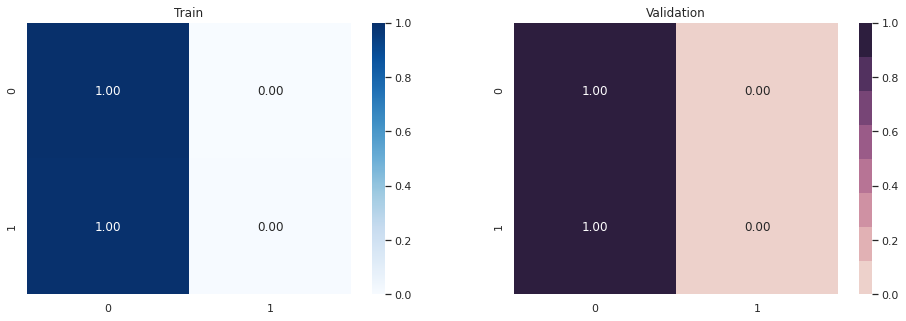

Fold: 2


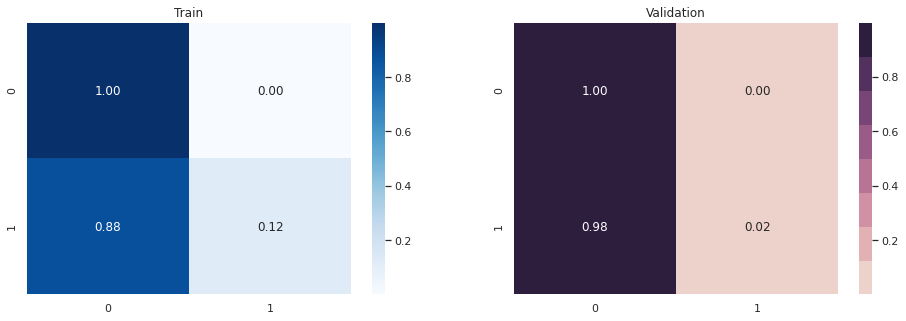

Fold: 3


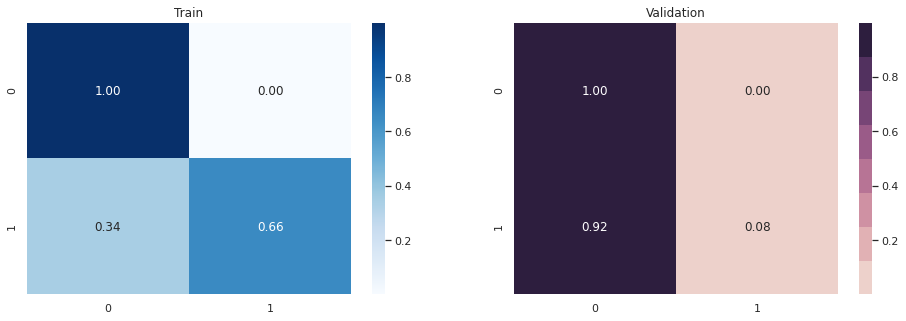

Fold: 4


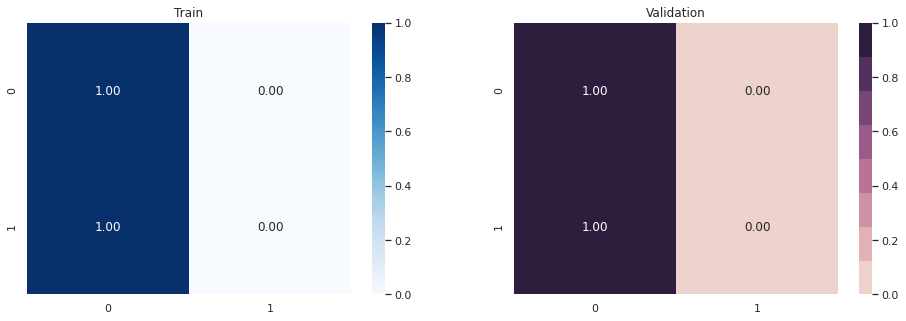

Fold: 5


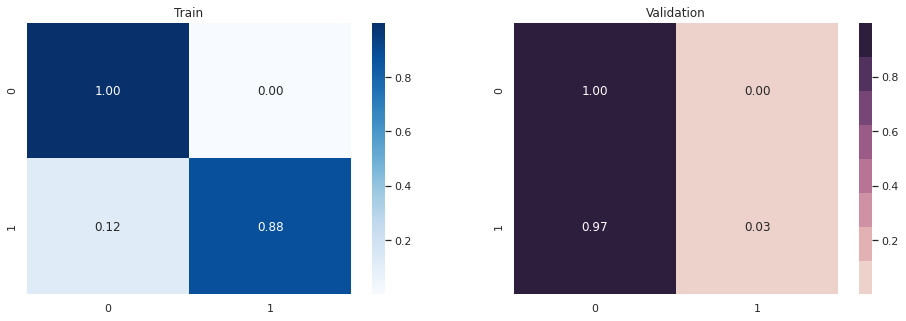

In [13]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    validation_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          validation_set['target'], np.round(validation_set[pred_col]))

# Visualize predictions

In [14]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred >= .5').head(10))

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.000229,0.000503,9.116530e-05,0.000121,0.000154,0.000278
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.000240,0.000567,1.498163e-04,0.000029,0.000254,0.000200
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.000582,0.000619,5.924702e-05,0.000280,0.001648,0.000303
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.000355,0.000404,9.113550e-05,0.001023,0.000252,0.000007
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.000264,0.000070,1.007318e-05,0.000068,0.000863,0.000312
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.000582,0.000174,1.446903e-04,0.000137,0.000882,0.001574
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.000159,0.000264,4.172325e-07,0.000439,0.000073,0.000016
7,ISIC_0075663,female,35.0,torso,unknown,0,0.002981,0.000639,1.229346e-04,0.000075,0.013685,0.000381
8,ISIC_0075914,male,30.0,torso,unknown,0,0.000840,0.000883,7.706583e-04,0.000018,0.001891,0.000639
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.000412,0.000858,5.149245e-04,0.000101,0.000527,0.000059


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.373983,0.000493,0.020498,0.905044,0.000980,0.942901
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.442595,0.006198,0.313249,0.896943,0.025605,0.970978
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.198460,0.002561,0.014044,0.000479,0.009840,0.965377
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.067484,0.004036,0.004478,0.214776,0.033321,0.080809
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.311162,0.012542,0.035541,0.549307,0.007027,0.951393
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.269692,0.003337,0.002620,0.829985,0.003689,0.508830
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.206631,0.011103,0.034882,0.515388,0.008398,0.463384
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.199827,0.004057,0.001692,0.009142,0.039519,0.944724
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.302281,0.019840,0.023458,0.600628,0.093999,0.773482
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.190923,0.036820,0.085298,0.003060,0.028335,0.801101


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.500300,0.098384,0.374538,0.971288,0.062741,0.994551
3119,ISIC_1037315,male,60.0,lower extremity,melanoma,1,0.505536,0.015729,0.706961,0.849702,0.024663,0.930627
6876,ISIC_2153401,female,40.0,lower extremity,melanoma,1,0.506018,0.075567,0.493126,0.918833,0.059006,0.983559
6959,ISIC_2176112,male,55.0,head/neck,melanoma,1,0.508155,0.075409,0.591820,0.891231,0.008270,0.974046
7107,ISIC_2221217,male,75.0,torso,melanoma,1,0.528851,0.172030,0.822588,0.731397,0.012885,0.905357
8139,ISIC_2535541,male,80.0,head/neck,melanoma,1,0.585159,0.140666,0.861356,0.915429,0.028267,0.980078
8927,ISIC_2776906,male,70.0,torso,melanoma,1,0.543328,0.080878,0.803748,0.772767,0.088589,0.970657
10813,ISIC_3338629,male,55.0,head/neck,melanoma,1,0.513194,0.002759,0.658126,0.912592,0.119120,0.873376
12012,ISIC_3697702,female,45.0,torso,melanoma,1,0.513223,0.070316,0.621821,0.888777,0.077105,0.908095
13782,ISIC_4230049,female,45.0,torso,melanoma,1,0.506657,0.007684,0.650418,0.916897,0.068275,0.890013
